# Deep Learning (LSTM model) approach to emotion classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from collections import defaultdict
from utils import plot_confusion_matrix, preprocess_word, EmotionDataset

## Data Preparation and Processing

In [44]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
emotion_dataset = EmotionDataset()

LABEL_TO_EMOTION_DICT = emotion_dataset.LABEL_TO_EMOTION_DICT
dataset = emotion_dataset.dataset

In [5]:
train_texts_l = dataset["train"]["text"]
train_labels_l = dataset["train"]["label"]

val_texts_l = dataset["validation"]["text"]
val_labels_l = dataset["validation"]["label"]

In [6]:
def process_sequences(seqs: list):
    stemmer = PorterStemmer()
    seqs_processed = []

    word_to_ix_dict = defaultdict(lambda: 0)
    word_to_ix_dict["<PAD>"] = 1
    i = max(word_to_ix_dict.values()) + 1
    for sentence in seqs:
        seq = word_tokenize(sentence)
        seq_processed = []
        for word in seq:
            word = stemmer.stem(word)
            seq_processed.append(word)
            if word not in word_to_ix_dict:
                word_to_ix_dict[word] = i
                i += 1
        seqs_processed.append(seq_processed)

    return seqs_processed, word_to_ix_dict

In [7]:
train_texts_processed, word_to_ix_dict = process_sequences(train_texts_l)
val_texts_processed, _ = process_sequences(val_texts_l)

In [8]:
word_to_ix_dict

defaultdict(<function __main__.process_sequences.<locals>.<lambda>()>,
            {'<PAD>': 1,
             'i': 2,
             'didnt': 3,
             'feel': 4,
             'humili': 5,
             'can': 6,
             'go': 7,
             'from': 8,
             'so': 9,
             'hopeless': 10,
             'to': 11,
             'damn': 12,
             'hope': 13,
             'just': 14,
             'be': 15,
             'around': 16,
             'someon': 17,
             'who': 18,
             'care': 19,
             'and': 20,
             'is': 21,
             'awak': 22,
             'im': 23,
             'grab': 24,
             'a': 25,
             'minut': 26,
             'post': 27,
             'greedi': 28,
             'wrong': 29,
             'am': 30,
             'ever': 31,
             'nostalg': 32,
             'about': 33,
             'the': 34,
             'fireplac': 35,
             'will': 36,
             'know': 37,
             

In [9]:
def data_generator(X: list, y: list, word_to_ix_dict: defaultdict, pad_ix: int, batch_size=10, epochs=100, shuffle=False):
    data_len = len(X)
    index_list = list(range(data_len))
    if shuffle:
        np.random.shuffle(index_list)

    curr_i = 0
    epoch = 0
    finished = False
    while not finished:
        X_batch, y_batch = [], []
        epoch_finished = False
        for _ in range(batch_size):
            seq = X[index_list[curr_i]]
            seq_indexed = [word_to_ix_dict[word] for word in seq]
            
            X_batch.append(seq_indexed)
            y_batch.append(y[index_list[curr_i]])

            curr_i += 1
            if curr_i >= data_len:
                epoch_finished = True
                epoch += 1
                if epoch == epochs:
                    finished = True
                    break

                curr_i = 0
                if shuffle:
                    np.random.shuffle(index_list)

        max_seq_length = max(len(seq) for seq in X_batch)
        X_batch = [seq + [pad_ix]*(max_seq_length-len(seq)) for seq in X_batch]

        yield X_batch, y_batch, epoch_finished

In [11]:
train_X_as_input, train_y_as_output, _ = next(data_generator(
    train_texts_processed,
    train_labels_l,
    word_to_ix_dict,
    word_to_ix_dict["<PAD>"],
    batch_size=len(train_texts_processed),
    epochs=1,
    shuffle=False
))

train_X_as_input = torch.tensor(train_X_as_input, device=DEVICE)
train_y_as_output = torch.tensor(train_y_as_output, device=DEVICE)


val_X_as_input, val_y_as_output, _ = next(data_generator(
    val_texts_processed,
    val_labels_l,
    word_to_ix_dict,
    word_to_ix_dict["<PAD>"],
    batch_size=len(val_texts_processed),
    epochs=1,
    shuffle=False
))

val_X_as_input = torch.tensor(val_X_as_input, device=DEVICE)
val_y_as_output = torch.tensor(val_y_as_output, device=DEVICE)

## Model building and training 

In [10]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, sentence):
        # input shape (batch_size, seq_length)
        embeds = self.embedding(sentence) # shape (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embeds) # shape (batch_size, seq_length, hidden_dim)
        linear_out = self.linear(lstm_out[:, -1, :]) # shape (batch_size, output_dim)
        logprobs = self.logsoftmax(linear_out) # shape (batch_size, output_dim)
        
        return logprobs

In [39]:
model = LSTMClassifier(64, 32, len(word_to_ix_dict)+1, len(LABEL_TO_EMOTION_DICT))
model = model.to(DEVICE)

loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
datagen = data_generator(
    train_texts_processed, 
    train_labels_l, 
    word_to_ix_dict, 
    word_to_ix_dict["<PAD>"],
    batch_size=64,
    epochs=80,
    shuffle=True
)

train_loss_history = []
val_loss_history = []
val_accuracies = []
i = 0
for X_batch, y_batch, epoch_finished in datagen:
    X_batch, y_batch = torch.tensor(X_batch, device=DEVICE), torch.tensor(y_batch, device=DEVICE)
    model.zero_grad()

    y_pred = model(X_batch)

    loss = loss_function(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    
    if epoch_finished:
        with torch.no_grad():
            y_train_pred = model(train_X_as_input)
            train_loss = loss_function(y_train_pred, train_y_as_output)
            train_loss_history.append(train_loss.item())

            y_val_pred = model(val_X_as_input)
            val_loss = loss_function(y_val_pred, val_y_as_output)
            val_loss_history.append(val_loss.item())

            pred_labels = y_val_pred.cpu().numpy().argmax(axis=1)
            accuracy = (pred_labels == np.array(val_labels_l)).mean()
            # accuracy = f1_score(val_labels_l, pred_labels, average="micro")
            val_accuracies.append(accuracy)
    i += 1

## Model evaluation

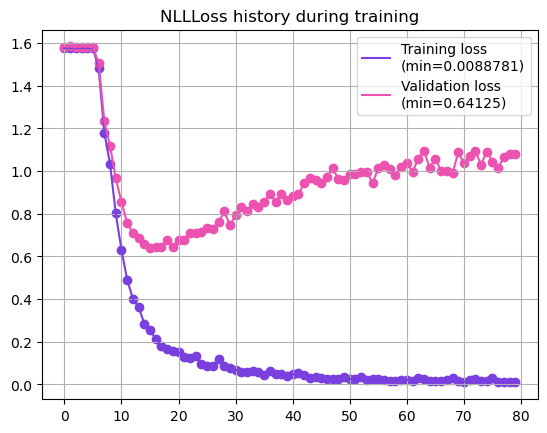

In [60]:
fig, ax = plt.subplots(1, 1)
temp_x = list(range(len(train_loss_history)))
ax.plot(temp_x, train_loss_history, label=f"Training loss\n(min={np.min(train_loss_history):.5})", color="#793FDF")
ax.scatter(temp_x, train_loss_history, color="#793FDF")

ax.plot(temp_x, val_loss_history, label=f"Validation loss\n(min={np.min(val_loss_history):.5})", color="#EC53B0")
ax.scatter(temp_x, val_loss_history, color="#EC53B0")

ax.set_title("NLLLoss history during training")
ax.legend()
ax.grid()
plt.show()

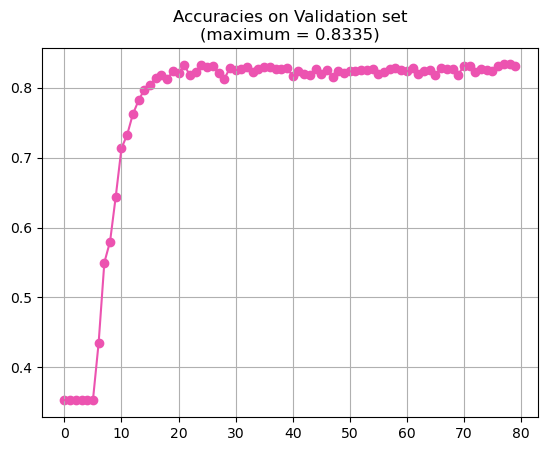

In [61]:
fig, ax = plt.subplots(1, 1)
temp_x = list(range(len(train_loss_history)))
ax.plot(temp_x, val_accuracies, color="#EC53B0")
ax.scatter(temp_x, val_accuracies, color="#EC53B0")

ax.set_title(f"Accuracies on Validation set\n(maximum = {np.max(val_accuracies)})")
ax.grid()
plt.show()